In [11]:
import wandb
api = wandb.Api()


In [12]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
group_name = "Sweep grid_size for tabular/cross-product without walls."
def access_func(config: dict):
    column_key = "test_data_args.sequence_args.grid_world_args.grid_size"
    for key in column_key.split("."):
        config = config[key]
    return config
column_key = "grid_size"
max_step = 1_000_000

In [14]:
import pandas as pd
runs = api.runs("rldl/icvi", {"$and": [{"group": group_name}]})

def generate_dfs():
    for run in runs:
        history = pd.DataFrame(run.history())
        # if history['_step'].max() < 300_000:
        #     continue
        history["seed"] = run.config["seed"]
        history["delta"] = run.config["bellman_delta"]
        history[column_key] = access_func(run.config)
        yield history

orig = pd.concat(list(generate_dfs()))
orig.columns

Index(['test-n/mae', 'test-1/regret', 'train-1/mae', '_step',
       'test-n/values-plot 113', 'test-n/values-plot 133',
       'test-1/values-plot 113', 'test-1/values-plot 133',
       'test-n/values-plot 156', 'test-1/values-plot 156', 'save_count',
       'test-1/rmse', 'train-1/rmse', 'test-n/argmax_accuracy', '_runtime',
       'lr', 'test-n/improved_policy_value', 'epoch', 'train-1/n',
       'test-1/improved_policy_value', 'fps', 'test-n/regret', 'test-n/rmse',
       'train-1/loss', 'test-1/mae', '_timestamp', 'train-1/argmax_accuracy',
       'test-1/argmax_accuracy', 'seed', 'delta', 'grid_size',
       'test-1/values-plot 31', 'test-n/values-plot 172',
       'test-1/values-plot 77', 'test-n/values-plot 77',
       'test-1/values-plot 172', 'test-n/values-plot 31',
       'test-1/values-plot 106', 'test-n/values-plot 136',
       'test-1/values-plot 136', 'test-n/values-plot 81',
       'test-1/values-plot 81', 'test-n/values-plot 106'],
      dtype='object')

In [15]:
df = orig.rename(columns={"_step": "step", "test-n/rmse": "test", "train-1/rmse": "train"})
# df = df[(df["delta"] == 1) | (df["delta"] == 100)]
df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")
df = df[df["step"] <= max_step]

df = df.melt(id_vars=['step', "delta", column_key],  # or any other columns you want to keep unchanged
                    value_vars=['test', 'train'],
                    var_name='regime',
                    value_name='root mean-square error')

df =df.rename(columns={"delta": "$\delta$"})
b = 5000
df['step'] = (df['step'] // b) * b
df.columns

Index(['step', '$\delta$', 'grid_size', 'regime', 'root mean-square error'], dtype='object')

In [16]:
df['$\delta$'].unique()

array(['$\\delta_{\\max}$', 20, 10, 2], dtype=object)

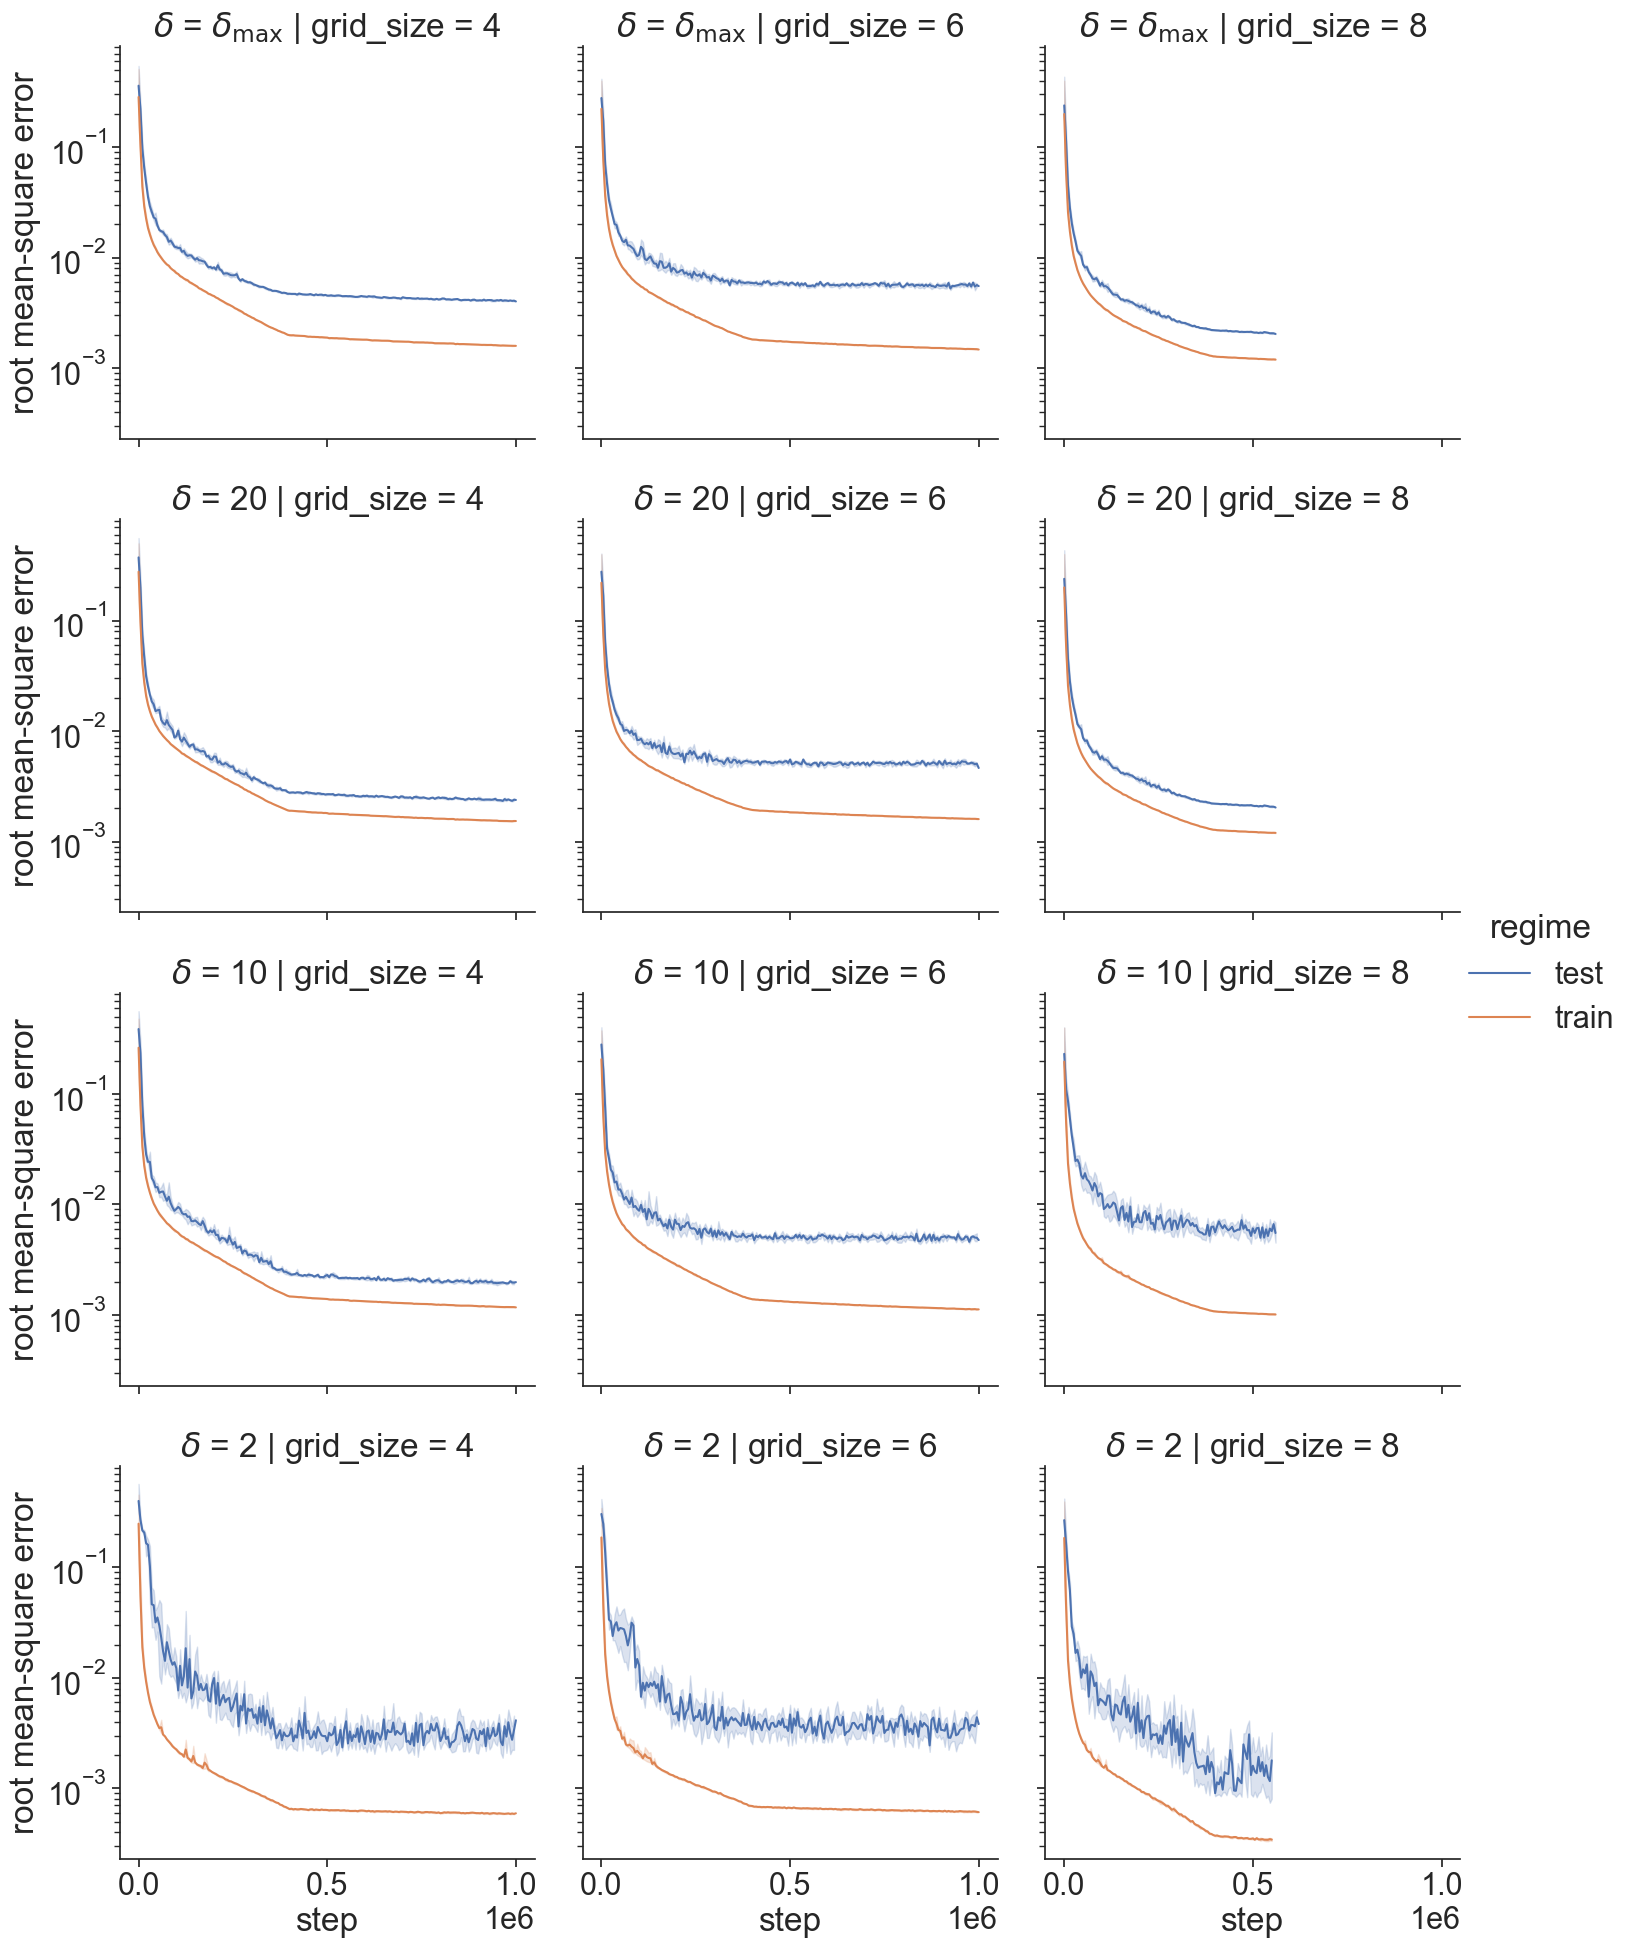

In [17]:
import seaborn as sns
sns.reset_defaults()

sns.set(font_scale=2)
sns.set_style('ticks')


g = sns.relplot(data=df, kind="line", x="step", y="root mean-square error", hue="regime", row="$\delta$", col=column_key)
g.set(yscale="log")
plt.show()

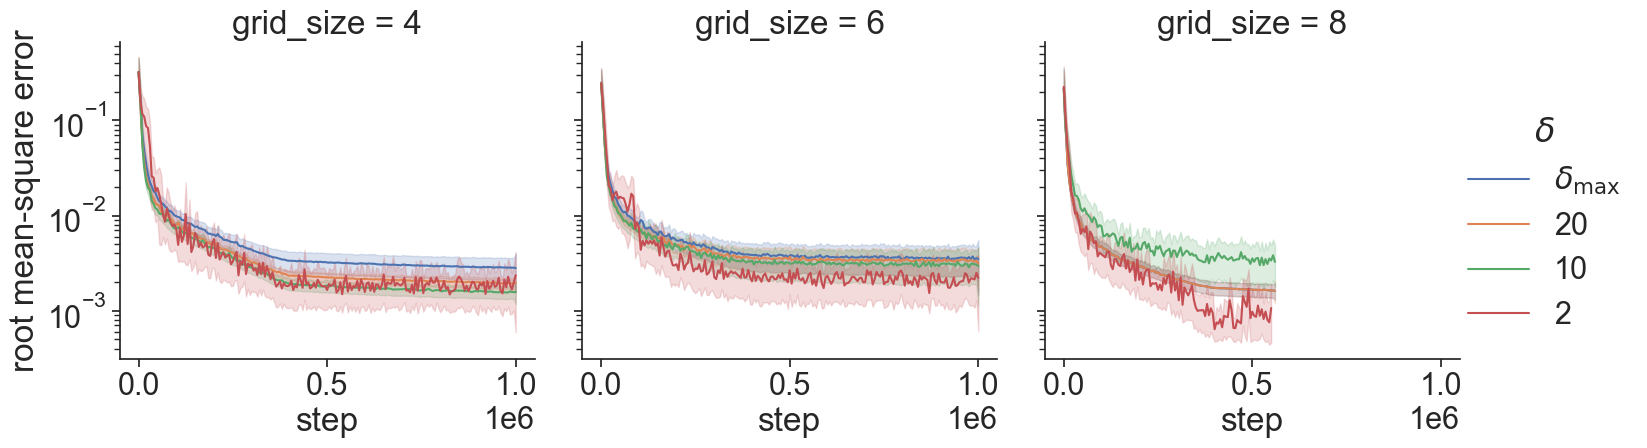

In [18]:
import seaborn as sns

sns.reset_defaults()
sns.set(font_scale=2)
sns.set_style('ticks')

g = sns.relplot(data=df, kind="line", x="step", y="root mean-square error", hue="$\delta$", col=column_key)
g.set(yscale="log")
plt.show()

In [19]:
df = orig.rename(columns={"_step": "step", "test-n/regret": "regret"})
df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")
df = df[df["step"] <= max_step]
df.loc[:, 'regret'] = df['regret'].clip(lower=1e-6)

window = 10
def calculate_stats(group):
    mean = group['regret'].rolling(window=window).mean()
    std = group['regret'].rolling(window=window).std()
    group['regret'] = mean
    group['upper'] = (mean + std).clip(lower=1e-6)
    group['lower'] = (mean - std).clip(lower=1e-6)
    return group

b = 5000
df.loc[:, 'step'] = (df['step'] // b) * b
df =df.rename(columns={"delta": "$\delta$", "regret": "regret of improved policy"})

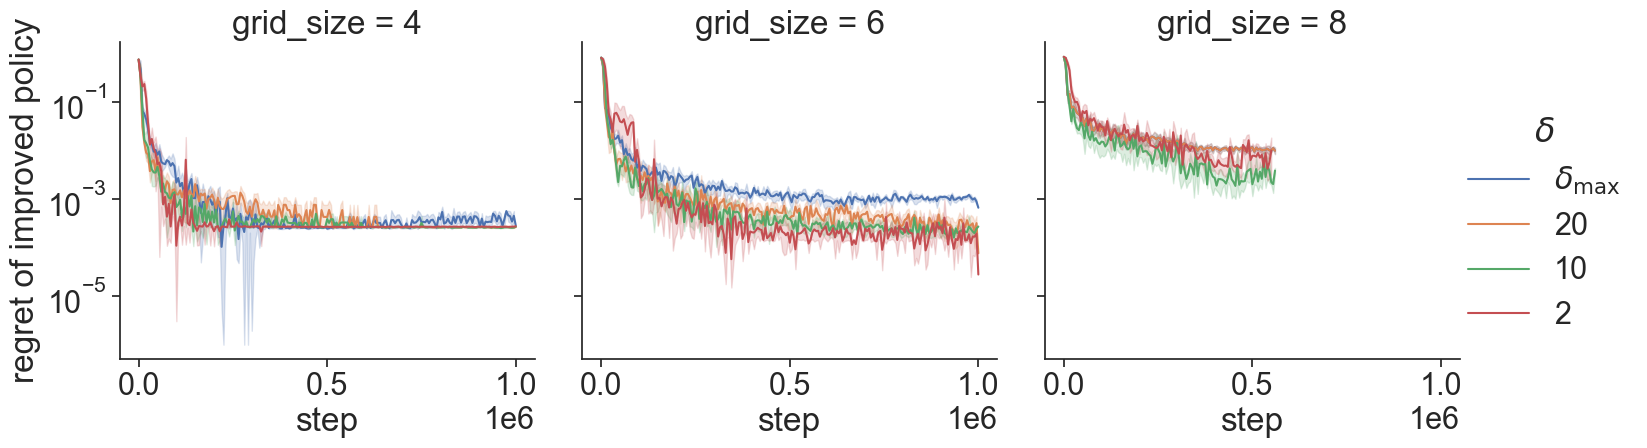

In [20]:
import seaborn as sns

sns.reset_defaults()
sns.set(font_scale=2)
sns.set_style('ticks')

g = sns.relplot(data=df, kind="line", x="step", y="regret of improved policy", hue="$\delta$", col=column_key)
g.set(yscale="log")
plt.show()

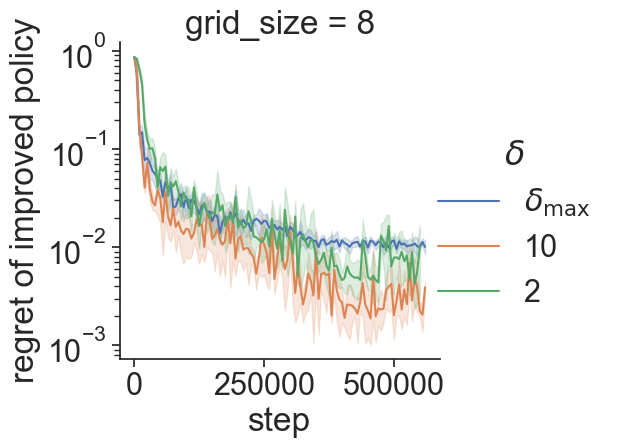

In [32]:

import seaborn as sns

sns.reset_defaults()
sns.set(font_scale=2)
sns.set_style('ticks')
_df = df[
    (df["grid_size"] == 8) & (
        ((df["$\\delta$"] != 20))
    )]

g = sns.relplot(data=_df, kind="line", x="step", y="regret of improved policy", hue="$\delta$", col=column_key)
g.set(yscale="log")
plt.show()